# **Cryptocurrency Price Prediction with LSTM**

*Student ID*: **20120454**

*Name*: **Lê Công Đắt**

> BTC-USD, ETH-USD, ADA-USD

### Connect to Google Drive

In [14]:
# Kết nối Google drive để lưu tài nguyên
from google.colab import drive
drive.mount('/content/drive')

# Chuyển đến thư mục
%cd /content/drive/My Drive/Individual AI Project/crypto

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/Individual AI Project/crypto


### Import libraries

In [15]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from matplotlib.pylab import rcParams
rcParams['figure.figsize']=20,10
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense, Input


from sklearn.preprocessing import MinMaxScaler

import yfinance as yf

from datetime import datetime
import time

### Get Stock data of BTC-USD (Bitcoin)

In [16]:
class YahooDailyReader():
    def __init__(self, symbol=None, start=None, end=None):
        """
        Khởi tạo YahooDailyReader với mã chứng khoán và khoảng thời gian.

        Tham số:
        symbol (str): Mã cổ phiếu, ví dụ: 'AAPL' cho Apple.
        start (datetime): Ngày bắt đầu để lấy dữ liệu lịch sử.
        end (datetime): Ngày kết thúc để lấy dữ liệu lịch sử.
        """

        self.symbol = symbol
        self.start = start
        self.end = end

        # Chuyển đổi ngày bắt đầu và ngày kết thúc sang định dạng Unix timestamp.
        unix_start = int(time.mktime(self.start.timetuple()))
        day_end = self.end.replace(hour=23, minute=59, second=59)
        unix_end = int(time.mktime(day_end.timetuple()))

    def read(self):
        """
        Lấy và phân tích dữ liệu lịch sử từ Yahoo Finance.

        Trả về:
        pandas.DataFrame: Một DataFrame chứa dữ liệu giá lịch sử.
        """

        # Lấy dữ liệu từ Yahoo Finance.
        stock_data = yf.download(self.symbol, start=self.start, end=self.end, interval='1d')

        # Chuyển đổi dữ liệu JSON thành một pandas DataFrame.
        df = pd.DataFrame(stock_data).reset_index()

         # Thêm mã cổ phiếu như một cột trong DataFrame.
        df.insert(1, 'symbolid', self.symbol)

        # Chuyển đổi Unix timestamps thành date objects.
        df['Date'] = pd.to_datetime(df['Date'], unit='s').dt.date

        # Loại bỏ các hàng mà giá 'Close' là NaN.
        df = df.dropna(subset=['Close'])

        # Đổi tên các cột.
        colnames = ['Date', 'symbolid', 'Open', 'High', 'Low', 'Close', 'AdjClose', 'Volume']
        df.columns = colnames

        # Đặt cột 'Date' làm index.
        df = df.set_index('Date')

        return df

In [17]:
symbol = 'BTC-USD'
start = datetime(1990, 1, 1)
end = datetime(2024, 6, 20)
reader = YahooDailyReader(symbol=symbol, start=start, end=end)
df = reader.read()
df.to_csv(f'csvdata/{symbol}.csv')
df.shape

[*********************100%%**********************]  1 of 1 completed


(3564, 7)

### Read the dataset

In [18]:
df=pd.read_csv(f'csvdata/{symbol}.csv')
df.head()

,Date,symbolid,Open,High,Low,Close,AdjClose,Volume
0,2014-09-17,BTC-USD,465.864014,468.174011,452.421997,457.334015,457.334015,21056800
1,2014-09-18,BTC-USD,456.859985,456.859985,413.104004,424.440002,424.440002,34483200
2,2014-09-19,BTC-USD,424.102997,427.834991,384.532013,394.795990,394.795990,37919700
3,2014-09-20,BTC-USD,394.673004,423.295990,389.882996,408.903992,408.903992,36863600
4,2014-09-21,BTC-USD,408.084991,412.425995,393.181000,398.821014,398.821014,26580100


### Analyze the closing prices from dataframe

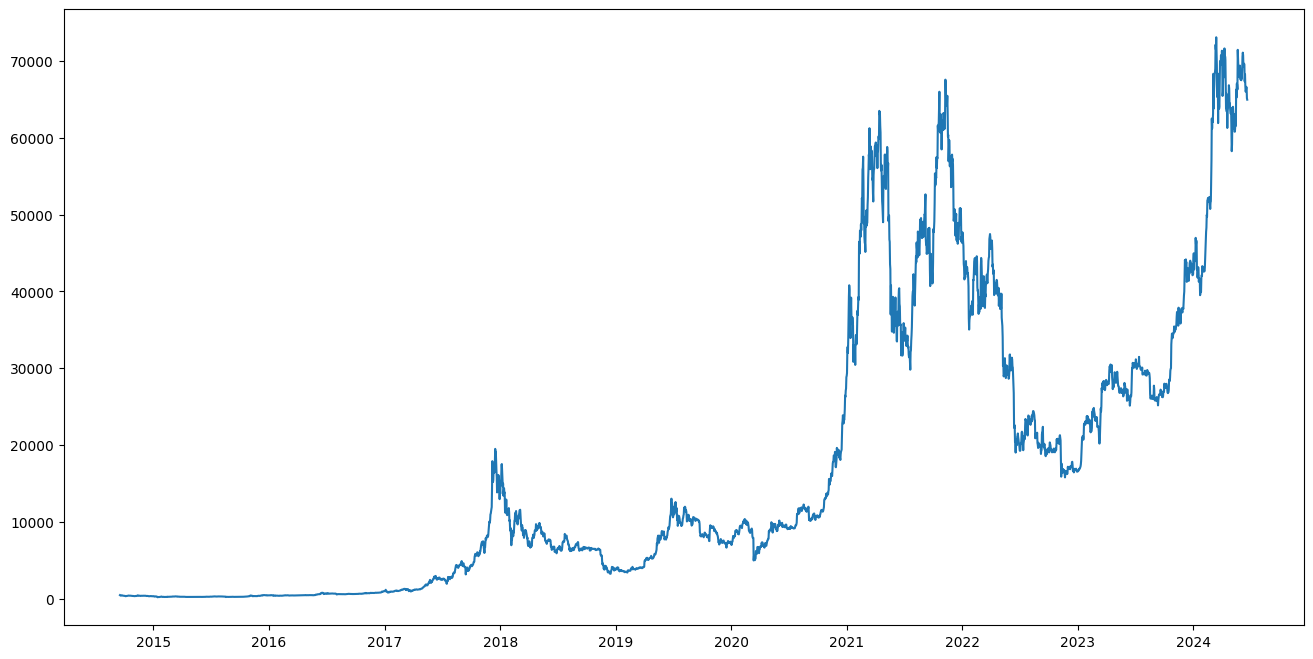

In [19]:
df["Date"]=pd.to_datetime(df.Date,format="%Y-%m-%d")
df.index=df['Date']

plt.figure(figsize=(16,8))
plt.plot(df["Close"],label='Close Price history')

### Sort the dataset on date time and filter “Date” and “Close” columns

In [20]:
data=df.sort_index(ascending=True,axis=0)
new_dataset=pd.DataFrame(index=range(0,len(df)),columns=['Date','Close'])

for i in range(0,len(data)):
    new_dataset["Date"][i]=data['Date'][i]
    new_dataset["Close"][i]=data["Close"][i]

new_dataset.tail()

,Date,Close
3559,2024-06-15 00:00:00,66191.0
3560,2024-06-16 00:00:00,66639.046875
3561,2024-06-17 00:00:00,66490.296875
3562,2024-06-18 00:00:00,65140.746094
3563,2024-06-19 00:00:00,64960.296875


### Normalize the new filtered dataset

In [21]:
new_dataset.index=new_dataset.Date
new_dataset.drop("Date",axis=1,inplace=True)

final_dataset=new_dataset.values

train_size = int(len(final_dataset) * 0.8)
train_data = final_dataset[:train_size, :]
valid_data = final_dataset[train_size:, :]

scaler=MinMaxScaler(feature_range=(0,1))
scaled_data=scaler.fit_transform(final_dataset)

x_train_data,y_train_data=[],[]

for i in range(60,len(train_data)):
    x_train_data.append(scaled_data[i-60:i,0])
    y_train_data.append(scaled_data[i,0])

x_train_data,y_train_data=np.array(x_train_data),np.array(y_train_data)

x_train_data=np.reshape(x_train_data,(x_train_data.shape[0],x_train_data.shape[1],1))


### Build and train the LSTM model

In [22]:
# Define the model
lstm_model = Sequential()

# Add an input layer
lstm_model.add(Input(shape=(x_train_data.shape[1], 1)))

# Add LSTM layers
lstm_model.add(LSTM(units=50, return_sequences=True))
lstm_model.add(LSTM(units=50))

# Add Dense layer
lstm_model.add(Dense(1))

# Compile the model
lstm_model.compile(loss='mean_squared_error', optimizer='adam')

# Fit the model
lstm_model.fit(x_train_data, y_train_data, epochs=1, batch_size=1, verbose=2)

2791/2791 - 79s - 28ms/step - loss: 0.0014


### Take a sample of a dataset to make stock price predictions using the LSTM model

In [23]:
inputs_data=new_dataset[len(new_dataset)-len(valid_data)-60:].values
inputs_data=inputs_data.reshape(-1,1)
inputs_data=scaler.transform(inputs_data)


X_test=[]
for i in range(60,inputs_data.shape[0]):
    X_test.append(inputs_data[i-60:i,0])
X_test=np.array(X_test)

X_test=np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1))
predicted_closing_price=lstm_model.predict(X_test)
predicted_closing_price=scaler.inverse_transform(predicted_closing_price)


23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step


### Save the LSTM model

In [24]:
lstm_model.save("saved_model.keras")
lstm_model.save("saved_model.h5")
lstm_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                        │ (None, 60, 50)              │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 91,955 (359.20 KB)

 Trainable params: 30,651 (119.73 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 61,304 (239.47 KB)

### Visualize the predicted cryptocurrency costs with actual cryptocurrency costs

<ipython-input-25-5c9ca86cff4b>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_data['Predictions']=predicted_closing_price


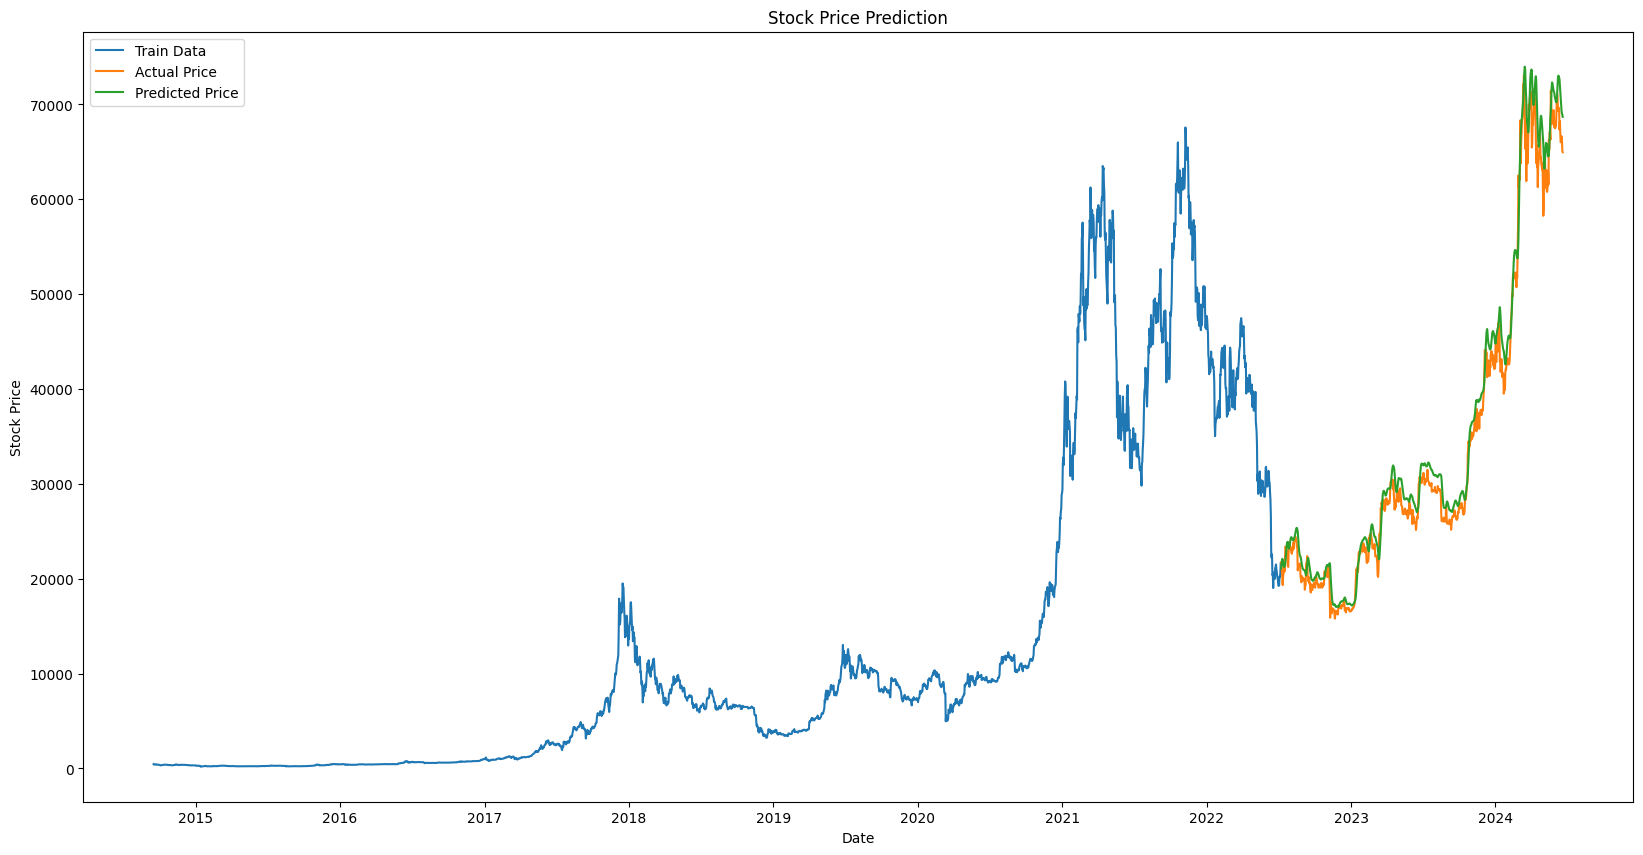

In [25]:
train_data=new_dataset[:train_size]
valid_data=new_dataset[train_size:]
valid_data['Predictions']=predicted_closing_price

plt.plot(train_data["Close"], label='Train Data')
plt.plot(valid_data["Close"], label='Actual Price')
plt.plot(valid_data["Predictions"], label='Predicted Price')

plt.legend()

plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('Stock Price Prediction')

plt.show()